## 1. Visualize các hàm kích hoạt

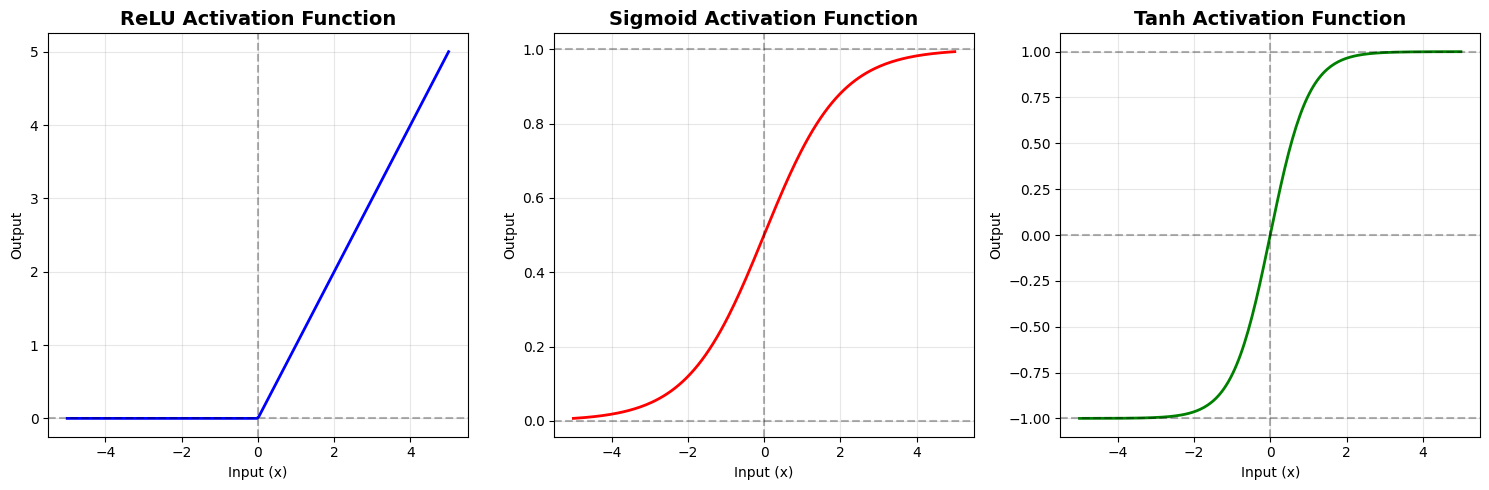

In [1]:
# Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

# Thiết lập random seed
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

# Visualize activation functions
x = np.linspace(-5, 5, 200)
relu = np.maximum(0, x)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)

plt.figure(figsize=(15, 5))

# ReLU
plt.subplot(1, 3, 1)
plt.plot(x, relu, 'b-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.title('ReLU Activation Function', fontsize=14, fontweight='bold')
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Sigmoid
plt.subplot(1, 3, 2)
plt.plot(x, sigmoid, 'r-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.title('Sigmoid Activation Function', fontsize=14, fontweight='bold')
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Tanh
plt.subplot(1, 3, 3)
plt.plot(x, tanh, 'g-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.title('Tanh Activation Function', fontsize=14, fontweight='bold')
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-1, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('images/01_activation_functions.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. So sánh các hàm kích hoạt trên bài toán Classification

### 2.1. Chuẩn bị dữ liệu

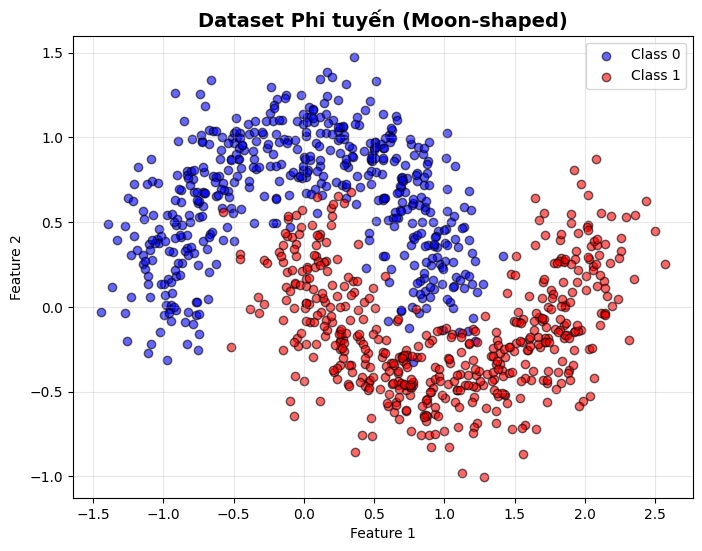

Training samples: 800
Test samples: 200
Features: 2


In [2]:
from sklearn.datasets import make_moons

# Tạo dữ liệu phi tuyến (moon-shaped)
X, y = make_moons(n_samples=1000, noise=0.2, random_state=random_state)

# Visualize dữ liệu
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.title('Dataset Phi tuyến (Moon-shaped)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/02_moon_dataset.png', dpi=150, bbox_inches='tight')
plt.show()

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Chuẩn hóa
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển sang PyTorch tensors
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train).unsqueeze(1)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test).unsqueeze(1)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

### 2.2. Xây dựng MLP với các hàm kích hoạt khác nhau

In [3]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron với khả năng chọn activation function
    """
    def __init__(self, input_dim, hidden_dim, output_dim, activation='relu'):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Chọn activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Activation must be 'relu', 'sigmoid', or 'tanh'")

        self.output_activation = nn.Sigmoid()  # Cho binary classification

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output_activation(self.fc3(x))
        return x

# Định nghĩa hyperparameters
input_dim = 2
hidden_dim = 64
output_dim = 1
learning_rate = 0.01
epochs = 500

### 2.3.  Training và So sánh

In [4]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, lr):
    """
    Hàm training model và lưu lại history
    """
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Calculate training accuracy
        with torch.no_grad():
            train_pred = (outputs > 0.5).float()
            train_acc = (train_pred == y_train).float().mean().item()
            train_accs.append(train_acc)

        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

            test_pred = (test_outputs > 0.5).float()
            test_acc = (test_pred == y_test).float().mean().item()
            test_accs.append(test_acc)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, '
                  f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    return train_losses, test_losses, train_accs, test_accs

# Training với ReLU
print("=" * 60)
print("Training MLP with ReLU Activation")
print("=" * 60)
model_relu = MLP(input_dim, hidden_dim, output_dim, activation='relu')
relu_train_loss, relu_test_loss, relu_train_acc, relu_test_acc = train_model(
    model_relu, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, learning_rate
)

# Training với Sigmoid
print("\n" + "=" * 60)
print("Training MLP with Sigmoid Activation")
print("=" * 60)
model_sigmoid = MLP(input_dim, hidden_dim, output_dim, activation='sigmoid')
sigmoid_train_loss, sigmoid_test_loss, sigmoid_train_acc, sigmoid_test_acc = train_model(
    model_sigmoid, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, learning_rate
)

# Training với Tanh
print("\n" + "=" * 60)
print("Training MLP with Tanh Activation")
print("=" * 60)
model_tanh = MLP(input_dim, hidden_dim, output_dim, activation='tanh')
tanh_train_loss, tanh_test_loss, tanh_train_acc, tanh_test_acc = train_model(
    model_tanh, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, learning_rate
)

Training MLP with ReLU Activation
Epoch [100/500], Loss: 0.0592, Train Acc: 0.9762, Test Acc: 0.9900
Epoch [200/500], Loss: 0.0514, Train Acc: 0.9787, Test Acc: 0.9800
Epoch [300/500], Loss: 0.0456, Train Acc: 0.9812, Test Acc: 0.9800
Epoch [400/500], Loss: 0.0399, Train Acc: 0.9800, Test Acc: 0.9800
Epoch [500/500], Loss: 0.0365, Train Acc: 0.9825, Test Acc: 0.9750

Training MLP with Sigmoid Activation
Epoch [100/500], Loss: 0.2795, Train Acc: 0.8788, Test Acc: 0.8700
Epoch [200/500], Loss: 0.0845, Train Acc: 0.9688, Test Acc: 0.9800
Epoch [300/500], Loss: 0.0684, Train Acc: 0.9737, Test Acc: 0.9850
Epoch [400/500], Loss: 0.0667, Train Acc: 0.9750, Test Acc: 0.9850
Epoch [500/500], Loss: 0.0657, Train Acc: 0.9750, Test Acc: 0.9850

Training MLP with Tanh Activation
Epoch [100/500], Loss: 0.0641, Train Acc: 0.9725, Test Acc: 0.9900
Epoch [200/500], Loss: 0.0539, Train Acc: 0.9812, Test Acc: 0.9800
Epoch [300/500], Loss: 0.0492, Train Acc: 0.9825, Test Acc: 0.9850
Epoch [400/500], Loss:

### 2.4. Visualize kết quả so sánh

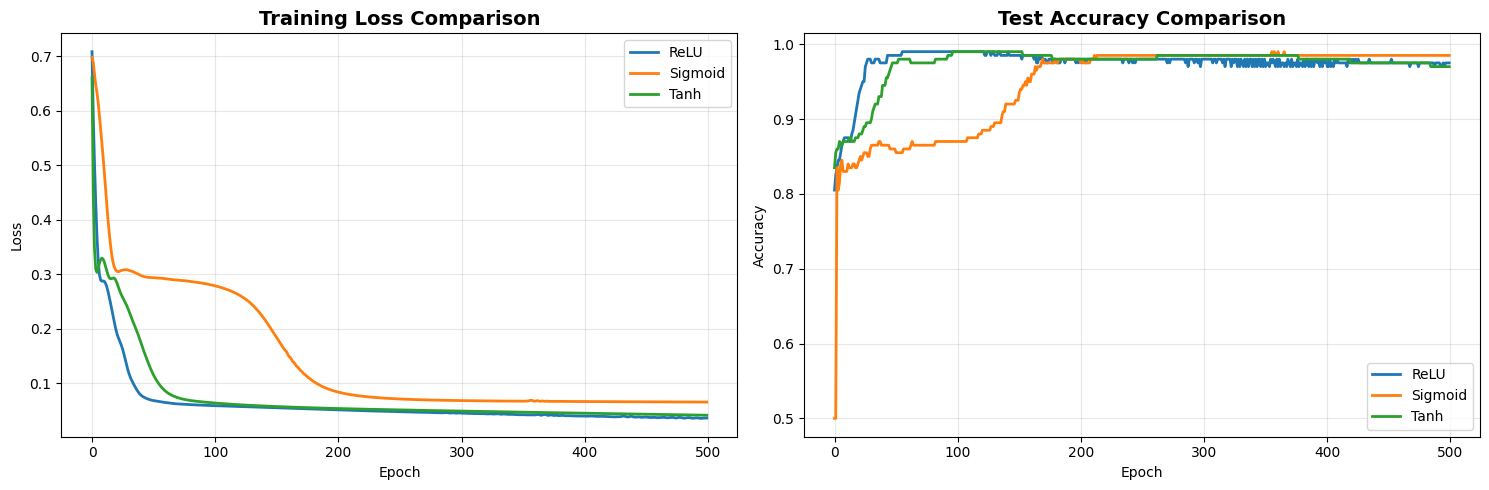


FINAL RESULTS COMPARISON
ReLU    - Train Acc: 0.9825 | Test Acc: 0.9750
Sigmoid - Train Acc: 0.9750 | Test Acc: 0.9850
Tanh    - Train Acc: 0.9812 | Test Acc: 0.9700


In [5]:
# So sánh Loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
axes[0].plot(relu_train_loss, label='ReLU', linewidth=2)
axes[0].plot(sigmoid_train_loss, label='Sigmoid', linewidth=2)
axes[0].plot(tanh_train_loss, label='Tanh', linewidth=2)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Accuracy
axes[1].plot(relu_test_acc, label='ReLU', linewidth=2)
axes[1].plot(sigmoid_test_acc, label='Sigmoid', linewidth=2)
axes[1].plot(tanh_test_acc, label='Tanh', linewidth=2)
axes[1].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/03_activation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# In kết quả cuối cùng
print("\n" + "=" * 60)
print("FINAL RESULTS COMPARISON")
print("=" * 60)
print(f"ReLU    - Train Acc: {relu_train_acc[-1]:.4f} | Test Acc: {relu_test_acc[-1]:.4f}")
print(f"Sigmoid - Train Acc: {sigmoid_train_acc[-1]:.4f} | Test Acc: {sigmoid_test_acc[-1]:.4f}")
print(f"Tanh    - Train Acc: {tanh_train_acc[-1]:.4f} | Test Acc: {tanh_test_acc[-1]:.4f}")

### 2.5. Visualize Decision Boundaries

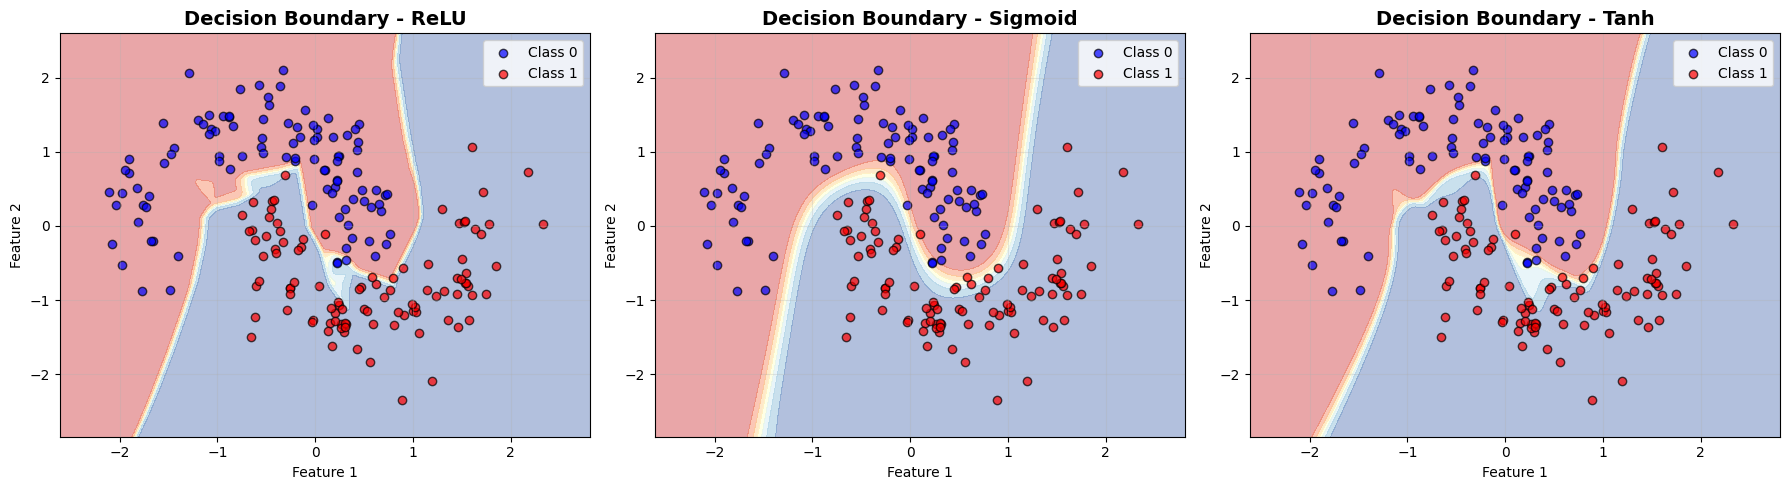

In [6]:
def plot_decision_boundary(model, X, y, title):
    """
    Vẽ decision boundary của model
    """
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict for each point in mesh
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.detach().numpy().reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='blue', label='Class 0', edgecolors='k', alpha=0.7)
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='red', label='Class 1', edgecolors='k', alpha=0.7)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Vẽ decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_decision_boundary(model_relu, X_test, y_test, 'Decision Boundary - ReLU')

plt.subplot(1, 3, 2)
plot_decision_boundary(model_sigmoid, X_test, y_test, 'Decision Boundary - Sigmoid')

plt.subplot(1, 3, 3)
plot_decision_boundary(model_tanh, X_test, y_test, 'Decision Boundary - Tanh')

plt.tight_layout()
plt.savefig('images/04_decision_boundaries.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Áp dụng các kỹ thuật cải thiện

### 3.1. MLP với Dropout

In [7]:
class MLP_Dropout(nn.Module):
    """
    MLP với Dropout để giảm overfitting
    """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(MLP_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)  # Dropout sau activation
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.output_activation(self.fc3(x))
        return x

# Training model với Dropout
print("=" * 60)
print("Training MLP with Dropout (rate=0.3)")
print("=" * 60)
model_dropout = MLP_Dropout(input_dim, hidden_dim, output_dim, dropout_rate=0.3)
dropout_train_loss, dropout_test_loss, dropout_train_acc, dropout_test_acc = train_model(
    model_dropout, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, learning_rate
)

Training MLP with Dropout (rate=0.3)
Epoch [100/500], Loss: 0.0902, Train Acc: 0.9675, Test Acc: 0.9850
Epoch [200/500], Loss: 0.0825, Train Acc: 0.9700, Test Acc: 0.9900
Epoch [300/500], Loss: 0.0625, Train Acc: 0.9750, Test Acc: 0.9750
Epoch [400/500], Loss: 0.0743, Train Acc: 0.9675, Test Acc: 0.9750
Epoch [500/500], Loss: 0.0564, Train Acc: 0.9762, Test Acc: 0.9800


### 3.2. MLP với Batch Normalization

In [8]:
class MLP_BatchNorm(nn.Module):
    """
    MLP với Batch Normalization
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_BatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Batch Norm trước activation
        x = self.activation(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)

        x = self.output_activation(self.fc3(x))
        return x

# Training model với Batch Normalization
print("=" * 60)
print("Training MLP with Batch Normalization")
print("=" * 60)
model_bn = MLP_BatchNorm(input_dim, hidden_dim, output_dim)
bn_train_loss, bn_test_loss, bn_train_acc, bn_test_acc = train_model(
    model_bn, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, learning_rate
)

Training MLP with Batch Normalization
Epoch [100/500], Loss: 0.0551, Train Acc: 0.9775, Test Acc: 0.9850
Epoch [200/500], Loss: 0.0458, Train Acc: 0.9825, Test Acc: 0.9750
Epoch [300/500], Loss: 0.0395, Train Acc: 0.9825, Test Acc: 0.9850
Epoch [400/500], Loss: 0.0366, Train Acc: 0.9787, Test Acc: 0.9600
Epoch [500/500], Loss: 0.0395, Train Acc: 0.9825, Test Acc: 0.9650


### 3.3. MLP với L2 Regularization (Weight Decay)

In [9]:
def train_model_with_l2(model, X_train, y_train, X_test, y_test, epochs, lr, weight_decay=0.01):
    """
    Training model với L2 regularization (weight decay)
    """
    criterion = nn.BCELoss()
    # Thêm weight_decay vào optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        with torch.no_grad():
            train_pred = (outputs > 0.5).float()
            train_acc = (train_pred == y_train).float().mean().item()
            train_accs.append(train_acc)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

            test_pred = (test_outputs > 0.5).float()
            test_acc = (test_pred == y_test).float().mean().item()
            test_accs.append(test_acc)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, '
                  f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    return train_losses, test_losses, train_accs, test_accs

# Training model với L2 Regularization
print("=" * 60)
print("Training MLP with L2 Regularization (weight_decay=0.01)")
print("=" * 60)
model_l2 = MLP(input_dim, hidden_dim, output_dim, activation='relu')
l2_train_loss, l2_test_loss, l2_train_acc, l2_test_acc = train_model_with_l2(
    model_l2, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, learning_rate, weight_decay=0.01
)

Training MLP with L2 Regularization (weight_decay=0.01)
Epoch [100/500], Loss: 0.1164, Train Acc: 0.9625, Test Acc: 0.9750
Epoch [200/500], Loss: 0.1143, Train Acc: 0.9625, Test Acc: 0.9750
Epoch [300/500], Loss: 0.1142, Train Acc: 0.9638, Test Acc: 0.9750
Epoch [400/500], Loss: 0.1142, Train Acc: 0.9638, Test Acc: 0.9750
Epoch [500/500], Loss: 0.1141, Train Acc: 0.9625, Test Acc: 0.9750


### 3.4. So sánh tất cả các kỹ thuật

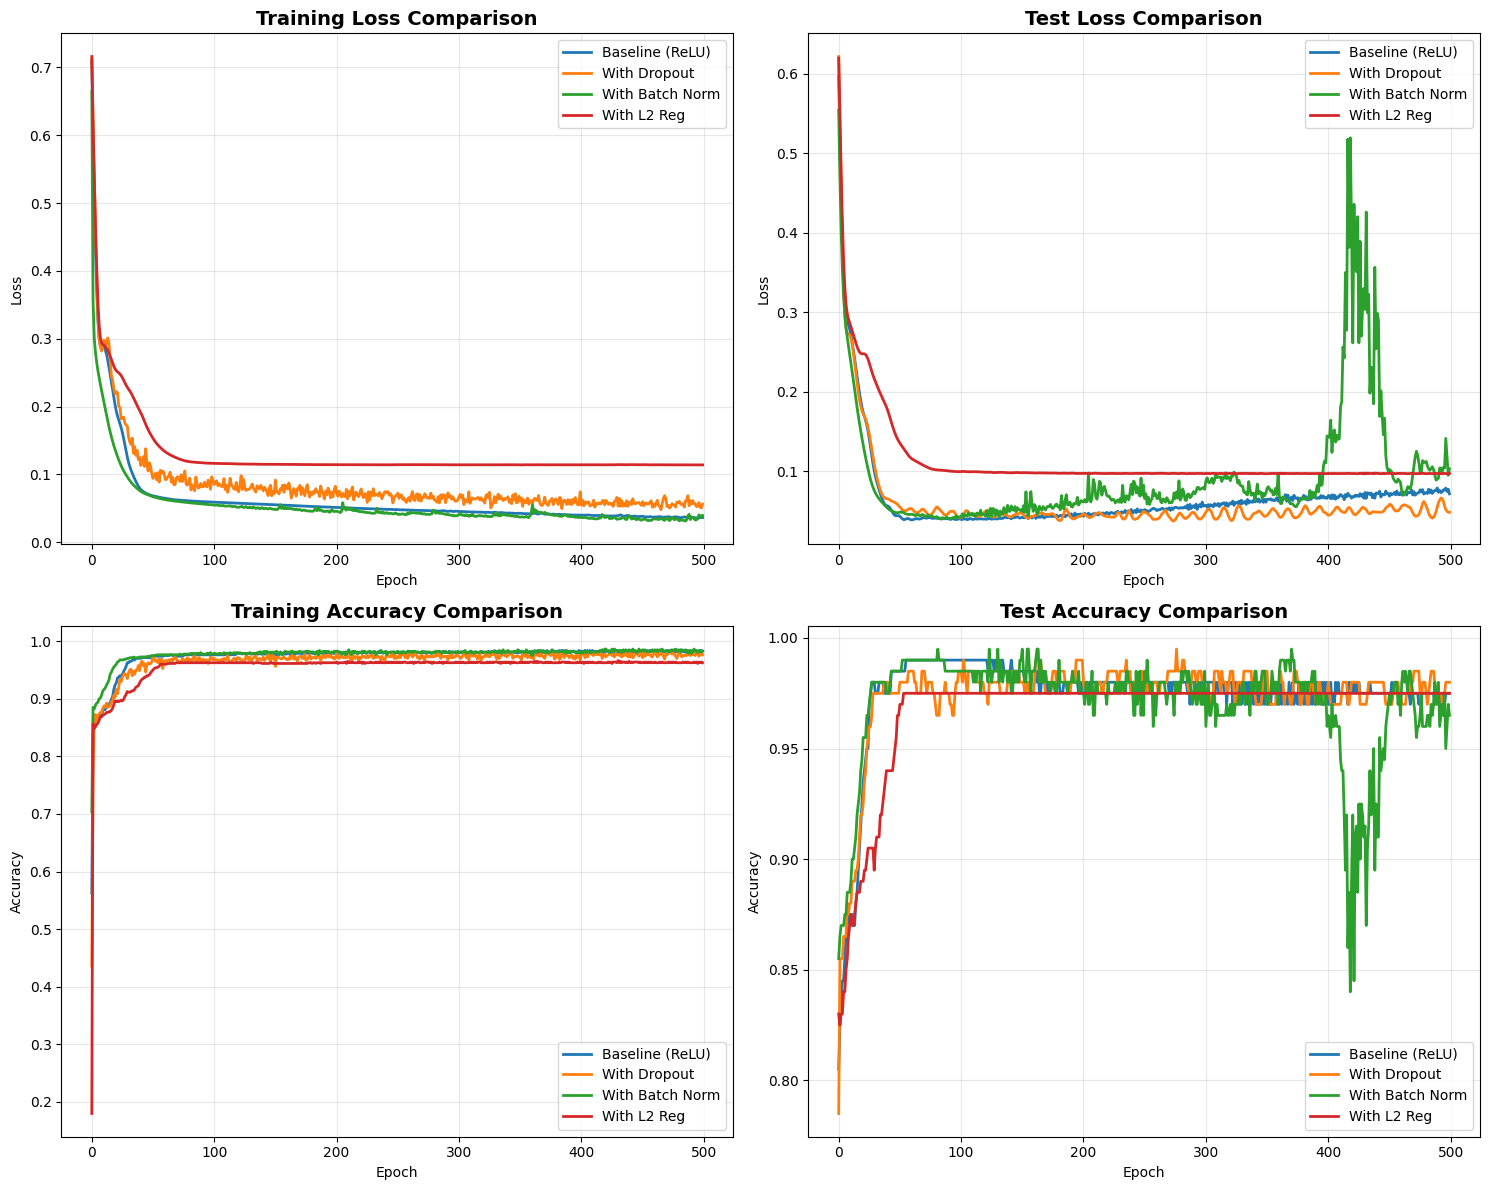


OVERFITTING ANALYSIS (Train-Test Accuracy Gap)
Baseline (ReLU): 0.0075
With Dropout:    -0.0038
With Batch Norm: 0.0175
With L2 Reg:     -0.0125

Note: Gap nhỏ hơn = ít overfitting hơn


In [10]:
# So sánh tất cả các kỹ thuật
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Training Loss
axes[0, 0].plot(relu_train_loss, label='Baseline (ReLU)', linewidth=2)
axes[0, 0].plot(dropout_train_loss, label='With Dropout', linewidth=2)
axes[0, 0].plot(bn_train_loss, label='With Batch Norm', linewidth=2)
axes[0, 0].plot(l2_train_loss, label='With L2 Reg', linewidth=2)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test Loss
axes[0, 1].plot(relu_test_loss, label='Baseline (ReLU)', linewidth=2)
axes[0, 1].plot(dropout_test_loss, label='With Dropout', linewidth=2)
axes[0, 1].plot(bn_test_loss, label='With Batch Norm', linewidth=2)
axes[0, 1].plot(l2_test_loss, label='With L2 Reg', linewidth=2)
axes[0, 1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
axes[1, 0].plot(relu_train_acc, label='Baseline (ReLU)', linewidth=2)
axes[1, 0].plot(dropout_train_acc, label='With Dropout', linewidth=2)
axes[1, 0].plot(bn_train_acc, label='With Batch Norm', linewidth=2)
axes[1, 0].plot(l2_train_acc, label='With L2 Reg', linewidth=2)
axes[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Test Accuracy
axes[1, 1].plot(relu_test_acc, label='Baseline (ReLU)', linewidth=2)
axes[1, 1].plot(dropout_test_acc, label='With Dropout', linewidth=2)
axes[1, 1].plot(bn_test_acc, label='With Batch Norm', linewidth=2)
axes[1, 1].plot(l2_test_acc, label='With L2 Reg', linewidth=2)
axes[1, 1].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/05_techniques_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Tính gap giữa train và test accuracy để đánh giá overfitting
print("\n" + "=" * 60)
print("OVERFITTING ANALYSIS (Train-Test Accuracy Gap)")
print("=" * 60)
print(f"Baseline (ReLU): {relu_train_acc[-1] - relu_test_acc[-1]:.4f}")
print(f"With Dropout:    {dropout_train_acc[-1] - dropout_test_acc[-1]:.4f}")
print(f"With Batch Norm: {bn_train_acc[-1] - bn_test_acc[-1]:.4f}")
print(f"With L2 Reg:     {l2_train_acc[-1] - l2_test_acc[-1]:.4f}")
print("\nNote: Gap nhỏ hơn = ít overfitting hơn")

### 4. Case Study - Dự đoán bệnh tim (Heart Disease)

### 4.1. Giới thiệu Dataset

Dataset **Heart Disease** từ UCI Machine Learning Repository chứa thông tin về bệnh nhân và khả năng mắc bệnh tim. Đây là một bài toán binary classification quan trọng trong y tế.

**Các đặc trưng chính:**

| Đặc trưng  | Mô tả                           | Ý nghĩa                            |
| ---------- | ------------------------------- | ---------------------------------- |
| `age`      | Tuổi                            | Tuổi cao → nguy cơ cao hơn         |
| `sex`      | Giới tính (1=male, 0=female)    | Nam giới thường có nguy cơ cao hơn |
| `cp`       | Chest Pain Type (0-3)           | Loại đau ngực                      |
| `trestbps` | Huyết áp khi nghỉ               | Huyết áp cao = nguy cơ cao         |
| `chol`     | Cholesterol                     | Cholesterol cao = nguy cơ cao      |
| `fbs`      | Fasting Blood Sugar > 120 mg/dl | Đường huyết cao                    |
| `restecg`  | Resting ECG results (0-2)       | Kết quả điện tâm đồ                |
| `thalach`  | Maximum Heart Rate              | Nhịp tim tối đa                    |
| `exang`    | Exercise Induced Angina         | Đau thắt ngực khi tập              |
| `oldpeak`  | ST depression                   | Chỉ số ST trên ECG                 |
| `slope`    | Slope of peak exercise ST       | Độ dốc ST                          |
| `ca`       | Number of major vessels (0-3)   | Số mạch máu chính                  |
| `thal`     | Thalassemia (0-3)               | Bệnh thalassemia                   |

### 4.2. Load và Khám phá Dữ liệu

In [11]:
# Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv(url, names=column_names)

print("=" * 60)
print("HEART DISEASE DATASET EXPLORATION")
print("=" * 60)
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nTarget distribution:")
print(df['target'].value_counts())

HEART DISEASE DATASET EXPLORATION

Dataset shape: (303, 14)

First 5 rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp     

### 4.3. Tiền xử lý Dữ liệu


AFTER PREPROCESSING
Target distribution after binarization:
target
0    164
1    139
Name: count, dtype: int64

Percentage:
target
0    54.125413
1    45.874587
Name: proportion, dtype: float64


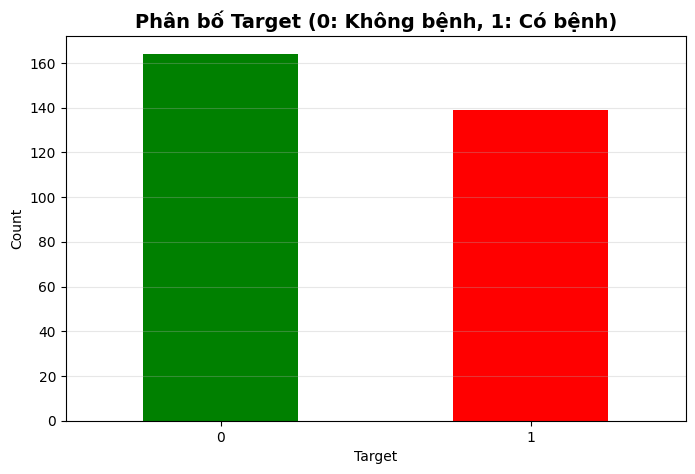

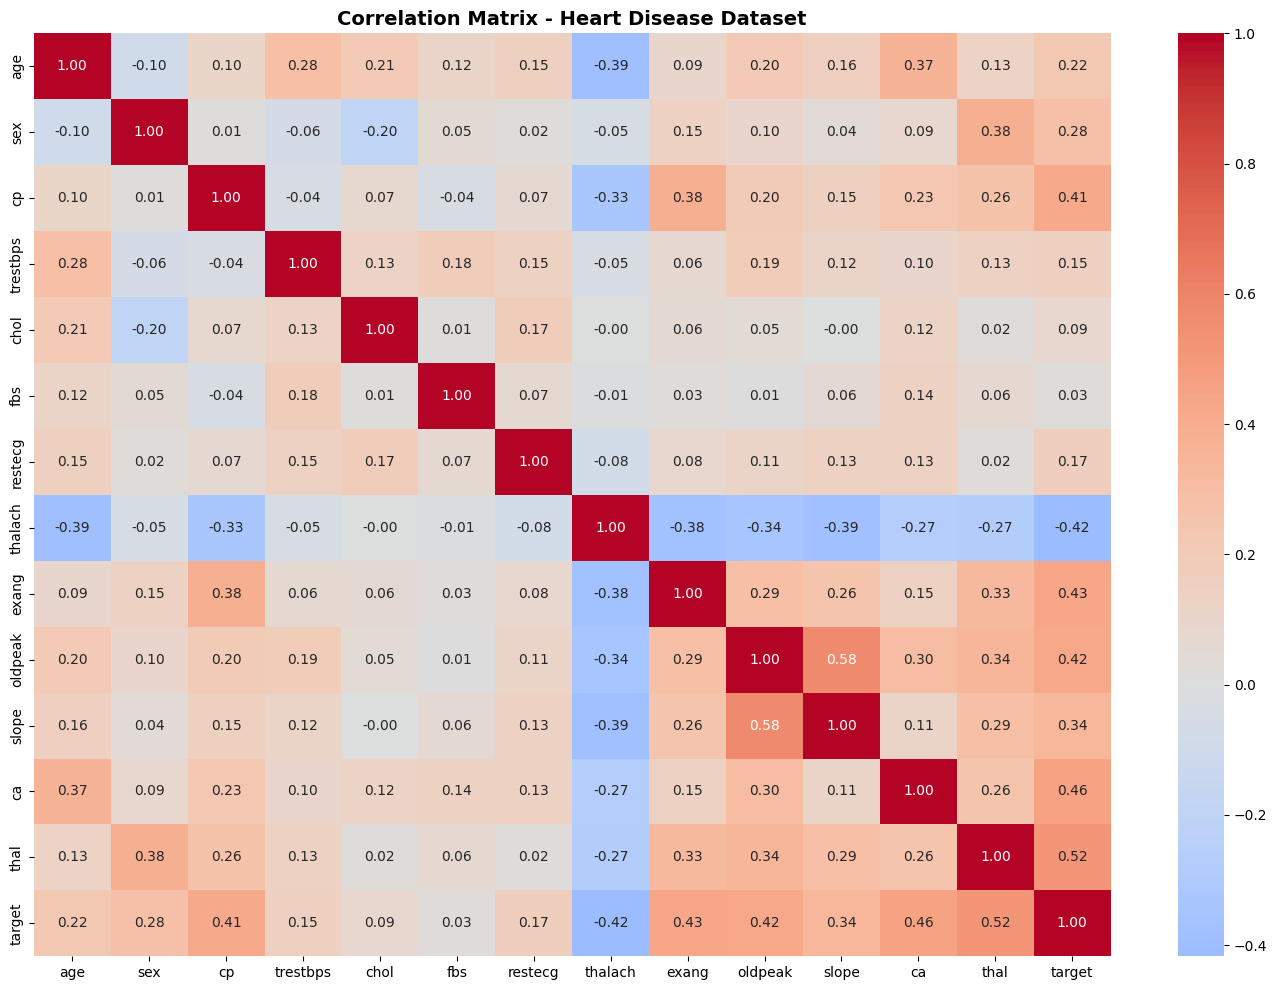


Training samples: 242
Test samples: 61
Number of features: 13


In [12]:
# Xử lý missing values (đánh dấu bởi '?')
df = df.replace('?', np.nan)

# Chuyển đổi sang numeric
df = df.apply(pd.to_numeric)

# Điền missing values bằng median
df = df.fillna(df.median())

# Chuyển target thành binary (0: không bệnh, 1: có bệnh)
df['target'] = (df['target'] > 0).astype(int)

print("\n" + "=" * 60)
print("AFTER PREPROCESSING")
print("=" * 60)
print(f"Target distribution after binarization:")
print(df['target'].value_counts())
print(f"\nPercentage:")
print(df['target'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(8, 5))
df['target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Phân bố Target (0: Không bệnh, 1: Có bệnh)', fontsize=14, fontweight='bold')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.savefig('images/06_heart_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualize correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Heart Disease Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/07_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Tách features và target
X = df.drop('target', axis=1).values
y = df['target'].values

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Chuẩn hóa
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển sang PyTorch tensors
X_train_heart = torch.FloatTensor(X_train)
y_train_heart = torch.FloatTensor(y_train).unsqueeze(1)
X_test_heart = torch.FloatTensor(X_test)
y_test_heart = torch.FloatTensor(y_test).unsqueeze(1)

### 4.4. Xây dựng MLP tối ưu

In [13]:
class OptimizedMLP(nn.Module):
    """
    MLP tối ưu kết hợp Batch Normalization, Dropout và ReLU
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.3):
        super(OptimizedMLP, self).__init__()

        # Layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.dropout1 = nn.Dropout(dropout_rate)

        # Layer 2
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer 3
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout3 = nn.Dropout(dropout_rate)

        # Output layer
        self.output = nn.Linear(hidden_dims[2], output_dim)

        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout3(x)

        # Output
        x = self.output_activation(self.output(x))
        return x

# Khởi tạo model
input_dim_heart = X_train.shape[1]
hidden_dims = [128, 64, 32]
output_dim_heart = 1
dropout_rate = 0.3

model_heart = OptimizedMLP(input_dim_heart, hidden_dims, output_dim_heart, dropout_rate)

print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
print(model_heart)
print(f"\nTotal parameters: {sum(p.numel() for p in model_heart.parameters())}")

MODEL ARCHITECTURE
OptimizedMLP(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (activation): ReLU()
  (output_activation): Sigmoid()
)

Total parameters: 12609


### 4.5. Training với Early Stopping

In [14]:
def train_with_early_stopping(model, X_train, y_train, X_test, y_test,
                               epochs, lr, patience=20, weight_decay=0.001):
    """
    Training với Early Stopping để tránh overfitting
    """
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    best_test_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        with torch.no_grad():
            train_pred = (outputs > 0.5).float()
            train_acc = (train_pred == y_train).float().mean().item()
            train_accs.append(train_acc)

        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

            test_pred = (test_outputs > 0.5).float()
            test_acc = (test_pred == y_test).float().mean().item()
            test_accs.append(test_acc)

        # Early Stopping
        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            model.load_state_dict(best_model_state)
            break

        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, '
                  f'Test Loss: {test_loss.item():.4f}, '
                  f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    return train_losses, test_losses, train_accs, test_accs

# Training
print("\n" + "=" * 60)
print("TRAINING HEART DISEASE MODEL")
print("=" * 60)
epochs_heart = 500
lr_heart = 0.001

train_loss_heart, test_loss_heart, train_acc_heart, test_acc_heart = train_with_early_stopping(
    model_heart, X_train_heart, y_train_heart, X_test_heart, y_test_heart,
    epochs_heart, lr_heart, patience=30, weight_decay=0.001
)


TRAINING HEART DISEASE MODEL
Epoch [50/500], Train Loss: 0.3409, Test Loss: 0.3295, Train Acc: 0.8554, Test Acc: 0.8852
Epoch [100/500], Train Loss: 0.2424, Test Loss: 0.3240, Train Acc: 0.9091, Test Acc: 0.8361

Early stopping at epoch 121


### 4.6. Đánh giá và Visualize kết quả

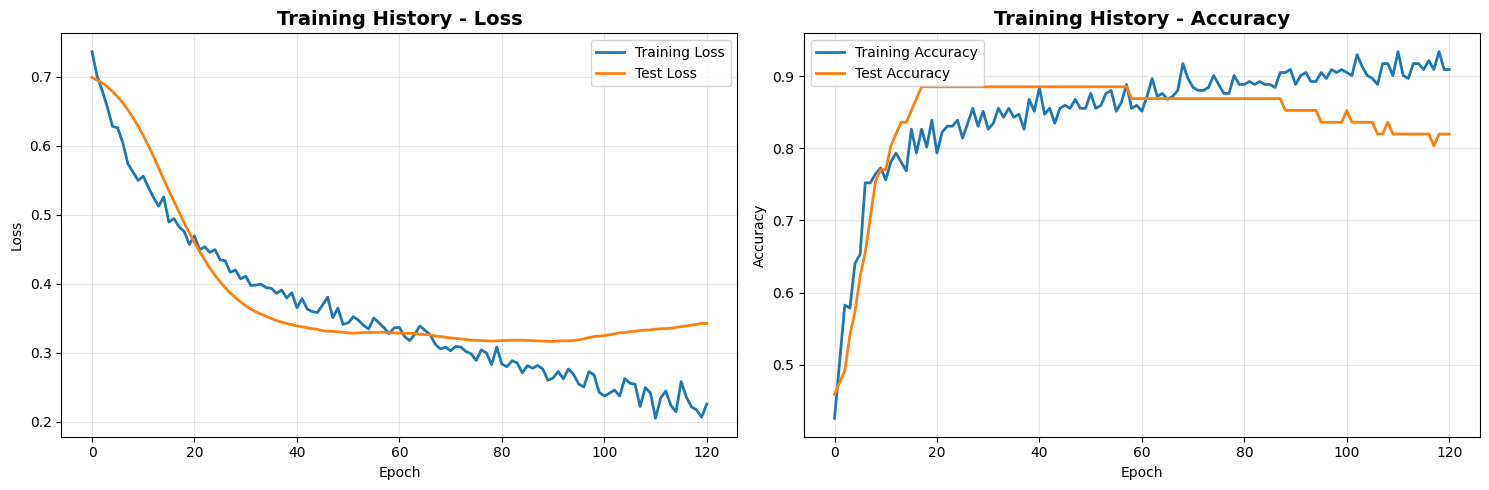


FINAL EVALUATION ON TEST SET
Accuracy: 0.8197

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.92      0.73      0.81        33
     Disease       0.74      0.93      0.83        28

    accuracy                           0.82        61
   macro avg       0.83      0.83      0.82        61
weighted avg       0.84      0.82      0.82        61



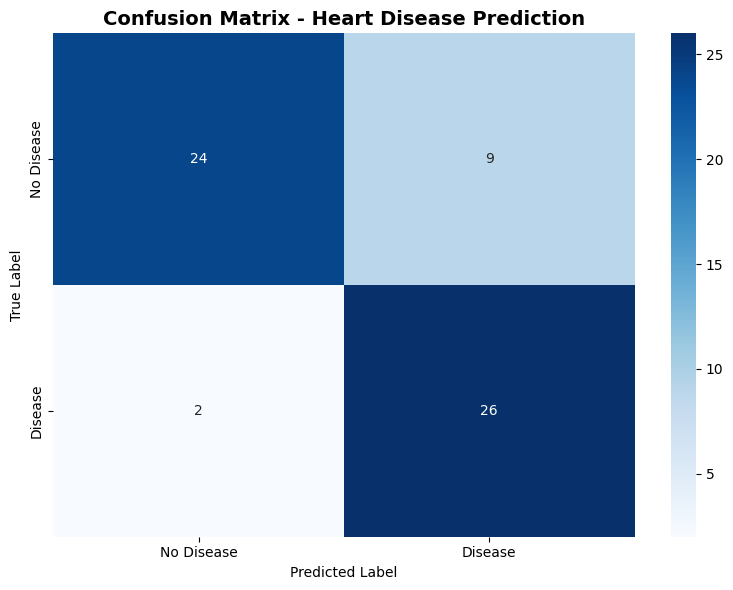

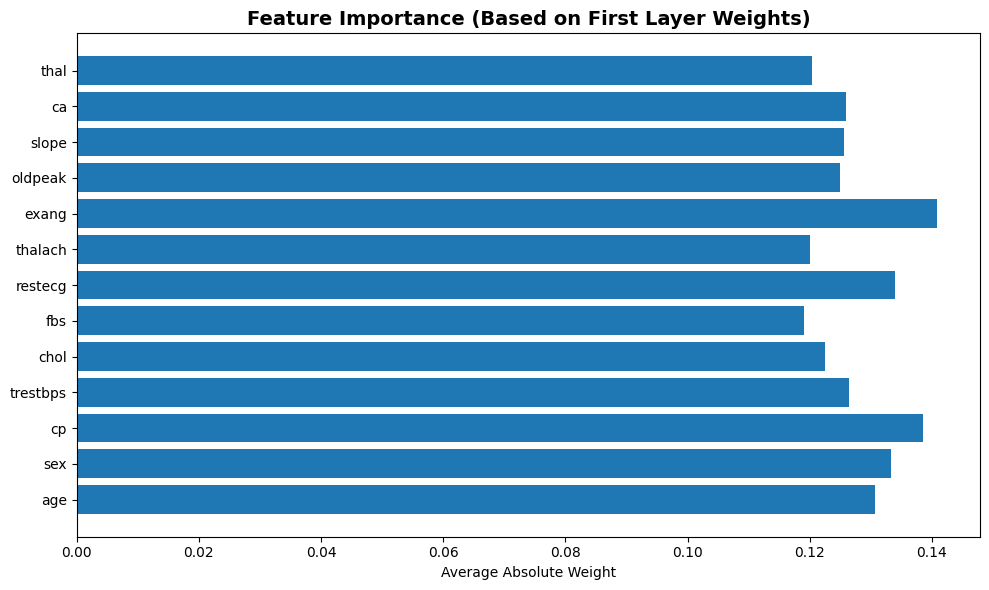


TOP 5 MOST IMPORTANT FEATURES
exang: 0.1408
cp: 0.1386
restecg: 0.1339
sex: 0.1333
age: 0.1307


In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(train_loss_heart, label='Training Loss', linewidth=2)
axes[0].plot(test_loss_heart, label='Test Loss', linewidth=2)
axes[0].set_title('Training History - Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_acc_heart, label='Training Accuracy', linewidth=2)
axes[1].plot(test_acc_heart, label='Test Accuracy', linewidth=2)
axes[1].set_title('Training History - Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/08_heart_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Đánh giá chi tiết
model_heart.eval()
with torch.no_grad():
    y_pred_proba = model_heart(X_test_heart).numpy()
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_true = y_test_heart.numpy()

accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print("\n" + "=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)
print(f"Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['No Disease', 'Disease']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Heart Disease Prediction', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('images/09_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Feature Importance Analysis (sử dụng trọng số của layer đầu tiên)
feature_names = column_names[:-1]  # Loại bỏ 'target'
weights = model_heart.fc1.weight.data.abs().mean(dim=0).numpy()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights)
plt.xlabel('Average Absolute Weight')
plt.title('Feature Importance (Based on First Layer Weights)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/10_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Top 5 most important features
top_indices = np.argsort(weights)[-5:]
print("\n" + "=" * 60)
print("TOP 5 MOST IMPORTANT FEATURES")
print("=" * 60)
for idx in top_indices[::-1]:
    print(f"{feature_names[idx]}: {weights[idx]:.4f}")